In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
import numpy as np 
import matplotlib.pyplot as plt
import glob
import cv2
import os
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Sequential


In [4]:
# re-size all the images to this
SIZE = 240

train_path = '/content/drive/MyDrive/Colab Notebooks/Masked Face Recognition/database/Train'
valid_path = '/content/drive/MyDrive/Colab Notebooks/Masked Face Recognition/database/Test'


In [10]:
# Training data and labels into respective lists
train_images = []
train_labels = []
training_data = []

for directory_path in glob.glob(os.path.join(train_path, "*")):
    label = directory_path.split("/")[-1]
    # print(label)
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        # print(img_path)
        img = cv2.imread(img_path)       
        img = cv2.resize(img, (SIZE,SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        train_images.append(img)
        train_labels.append(label)
        training_data.append([train_images,train_labels])

train_images = np.array(train_images)
train_labels = np.array(train_labels)
training_data = np.array(training_data)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [11]:
training_data = np.array(training_data,dtype=object)

In [12]:
len(train_labels)

680

In [13]:
type(train_images[0])

numpy.ndarray

In [14]:
# type(validation_data[0])

In [15]:
test_images = []
test_labels = []
validation_data = []

for directory_path in glob.glob(os.path.join(valid_path,"*")):
    label = directory_path.split("/")[-1]
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        test_images.append(img)
        test_labels.append(label)
        validation_data.append([train_images,train_labels])

test_images = np.array(test_images)
test_labels = np.array(test_labels)
# validation_data = np.array(validation_data)

In [16]:
test_labels

array(['Geetansh', 'Geetansh', 'Geetansh', 'Geetansh', 'Geetansh',
       'Geetansh', 'Geetansh', 'Geetansh', 'Geetansh', 'Geetansh',
       'Varsha', 'Varsha', 'Varsha', 'Varsha', 'Varsha', 'Varsha',
       'Varsha', 'Varsha', 'Varsha', 'Varsha', 'Varsha', 'Varsha',
       'Sahil', 'Sahil', 'Sahil', 'Sahil', 'Sahil', 'Sahil', 'Sahil',
       'Sahil', 'Sahil', 'Sahil', 'Sahil', 'Sahil', 'Kamya', 'Kamya',
       'Kamya', 'Kamya', 'Kamya', 'Kamya', 'Kamya', 'Kamya', 'Kamya',
       'Kamya', 'Kamya', 'Kamya'], dtype='<U8')

In [17]:
#Encode labels from text to integers.
from sklearn import preprocessing
encoder = preprocessing.LabelEncoder()
encoder.fit(train_labels)
train_labels_encoded = encoder.transform(train_labels)
encoder.fit(test_labels)
test_labels_encoded = encoder.transform(test_labels)

In [18]:
test_labels_encoded

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1])

In [19]:
#Inverse transform to get original label back. 
prediction_RF = encoder.inverse_transform([2])
prediction_RF

array(['Sahil'], dtype='<U8')

In [20]:
train_images = np.array(train_images).reshape(-1,SIZE,SIZE,3)
train_images=np.array(train_images)
train_images.shape

(680, 240, 240, 3)

In [21]:
train_labels=np.array(train_labels)
train_labels.shape

(680,)

In [22]:
x_train, y_train, x_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded

In [23]:
# Loading model
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3))

58900480/58889256 [==============================] - 0s 0us/step


In [24]:
len(os.listdir(train_path))

4

In [25]:
# vgg16.output.shape
type(vgg16.layers[0])

keras.engine.input_layer.InputLayer

In [26]:
for layer in vgg16.layers:
    layer.trainable = False

In [27]:
flatten = Flatten()(vgg16.output)
dense1 = Dense(128,activation='relu')(flatten)
dense2 = Dense(64,activation='relu')(dense1)
dense3 = Dense(16,activation='relu')(dense2)
prediction = Dense(len(os.listdir(train_path)), activation='softmax')(dense3)

model = Model(inputs=vgg16.input, outputs=prediction)

In [28]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 240, 240, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 240, 240, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 120, 120, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 120, 120, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 120, 120, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 60, 60, 128)       0     

In [29]:
# tell the model what cost and optimization method to use
model.compile(optimizer='adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
              metrics=['accuracy'])

In [30]:
result = model.fit(x_train,y_train,batch_size=32,
                   validation_data=(x_test,y_test),
                   epochs = 10)

Epoch 1/10
22/22 [==============================] - 21s 358ms/step - loss: 2.5656 - accuracy: 0.7750 - val_loss: 1.7595 - val_accuracy: 0.6739
Epoch 2/10
22/22 [==============================] - 4s 191ms/step - loss: 0.0070 - accuracy: 0.9971 - val_loss: 0.4032 - val_accuracy: 0.8913
Epoch 3/10
22/22 [==============================] - 4s 193ms/step - loss: 1.5849e-04 - accuracy: 1.0000 - val_loss: 0.2325 - val_accuracy: 0.9130
Epoch 4/10
22/22 [==============================] - 4s 195ms/step - loss: 5.0174e-05 - accuracy: 1.0000 - val_loss: 0.2198 - val_accuracy: 0.9130
Epoch 5/10
22/22 [==============================] - 4s 198ms/step - loss: 3.7167e-05 - accuracy: 1.0000 - val_loss: 0.2266 - val_accuracy: 0.9130
Epoch 6/10
22/22 [==============================] - 4s 200ms/step - loss: 3.1108e-05 - accuracy: 1.0000 - val_loss: 0.2299 - val_accuracy: 0.9130
Epoch 7/10
22/22 [==============================] - 4s 202ms/step - loss: 2.7968e-05 - accuracy: 1.0000 - val_loss: 0.2329 - val_ac

In [31]:
from tensorflow.keras.models import load_model
model.save('/content/drive/MyDrive/Colab Notebooks/Masked Face Recognition/model_vgg16.h5')

In [32]:
y_pred = model.predict(test_images)

In [33]:
y_pred

array([[1.00000000e+00, 3.41815021e-22, 7.48472058e-14, 1.37947342e-21],
       [1.00000000e+00, 8.25855676e-19, 5.66219380e-13, 1.67436206e-19],
       [1.00000000e+00, 2.53100978e-32, 1.12821242e-18, 8.06634079e-30],
       [1.00000000e+00, 6.08886941e-28, 1.40844586e-16, 1.84127987e-25],
       [1.00000000e+00, 7.06446966e-23, 3.20307305e-14, 2.15042877e-22],
       [1.00000000e+00, 2.34730148e-25, 7.89172338e-16, 8.62231722e-23],
       [1.00000000e+00, 3.10213641e-31, 7.79179942e-19, 9.39073134e-30],
       [1.00000000e+00, 6.53820691e-22, 3.49647665e-13, 7.32990994e-21],
       [1.00000000e+00, 3.81974531e-29, 9.13219142e-18, 9.98594965e-28],
       [1.00000000e+00, 1.08469723e-26, 3.17822048e-17, 9.35478223e-26],
       [2.36063273e-25, 2.43815066e-05, 7.31937380e-26, 9.99975562e-01],
       [3.33018779e-17, 4.60283220e-01, 2.14252749e-14, 5.39716840e-01],
       [1.27651910e-15, 2.81124911e-03, 6.17411717e-15, 9.97188747e-01],
       [2.80098229e-25, 2.34530344e-05, 8.18803538e

In [34]:
import numpy as np
y_pred = np.argmax(y_pred, axis=1)

In [35]:
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1])

In [36]:
y_pred = encoder.inverse_transform(y_pred)

In [37]:
y_pred

array(['Geetansh', 'Geetansh', 'Geetansh', 'Geetansh', 'Geetansh',
       'Geetansh', 'Geetansh', 'Geetansh', 'Geetansh', 'Geetansh',
       'Varsha', 'Varsha', 'Varsha', 'Varsha', 'Varsha', 'Varsha',
       'Varsha', 'Varsha', 'Kamya', 'Kamya', 'Kamya', 'Kamya', 'Sahil',
       'Sahil', 'Sahil', 'Sahil', 'Sahil', 'Sahil', 'Sahil', 'Sahil',
       'Sahil', 'Sahil', 'Sahil', 'Sahil', 'Kamya', 'Kamya', 'Kamya',
       'Kamya', 'Kamya', 'Kamya', 'Kamya', 'Kamya', 'Kamya', 'Kamya',
       'Kamya', 'Kamya'], dtype='<U8')

In [38]:
#Print overall accuracy
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, y_pred))

Accuracy =  0.9130434782608695


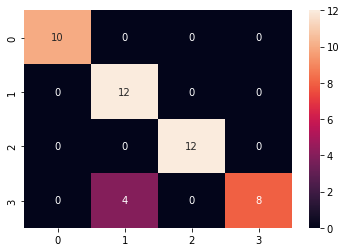

In [39]:
#Confusion Matrix - accuracy of each class
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_labels, y_pred)
sns.heatmap(cm, annot=True)

The prediction for this image is:  ['Varsha']
The actual label for this image is:  Varsha


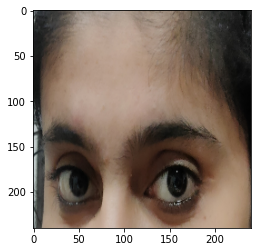

In [57]:
# For selected images
n=np.random.randint(0, x_test.shape[0])
img = x_test[n]
# img = 
plt.imshow(img)
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
pred=model.predict(input_img)
pred = np.argmax(pred, axis=1)
pred = encoder.inverse_transform([pred])  #Reverse the label encoder to original name
print("The prediction for this image is: ", pred)
print("The actual label for this image is: ", test_labels[n])
